In [ ]:
import pickle
import numpy as np
window_col_bad = pickle.load(open('./data_saved/window_col_bad.p','rb'))
window_col_good = pickle.load(open('./data_saved/window_col_good.p','rb'))
print(len(window_col_bad)+len(window_col_good))
window_col = window_col_good + window_col_bad
labels = np.array([0]*len(window_col_good) + [1]*len(window_col_bad))

In [ ]:
import numpy as np
from scipy import signal
from scipy.stats import skew,kurtosis
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler
def get_metric(x):
    x = RobustScaler().fit_transform(np.array(x).reshape(-1,1))[:,0]
    f,pxx = signal.welch(x,fs=25,nperseg=len(x)//2)
    pxx = np.abs(pxx)
    pxx = pxx/max(pxx)
    relative_power =  np.trapz(pxx[np.where((f>.8)&(f<2.5))[0]])/np.trapz(pxx[np.where(f>=0)[0]])
    relative_peak_power = np.std(pxx[np.where((f>.8)&(f<2.5))[0]])/np.max(pxx[np.where((f>.8)&(f<2.5))[0]])
    relative_peak_power = relative_peak_power/(relative_peak_power+np.std(pxx)/np.max(pxx))
    peaks_loc1,u = signal.find_peaks(pxx,height=.01)
    a = 0
    b = 0
    for p in peaks_loc1:
        if f[p]>0:
            if .8<f[p]<2.5:
                a+=pxx[p]
            b+=pxx[p]
    if len(peaks_loc1)==0 or a==0:
        relative_peak_power = 0
    else:
        relative_peak_power = a/b
    sk,kr = skew(x),kurtosis(x)
    return [sk,kr,relative_power,relative_peak_power]
feature = np.zeros((0,6))
for i,a in enumerate(window_col):
    if a.shape[0]<50:
        continue
    if 1<(a[-1,0]-a[0,0])/1000<10:
        tmp = get_metric(a[:,4])
        if labels[i]==1:
            if tmp[-1]!=0:
                continue
        duration = (a[-1,0]-a[0,0])/1000
        tmp = tmp + [duration,labels[i]]
        feature = np.concatenate((feature,np.array(tmp).reshape(-1,6)))

In [ ]:
%matplotlib inline
# plt.scatter(feature[:,3],[1]*feature.shape[0],c=feature[:,-1])
# plt.boxplot([feature[feature[:,-1]==0,2],feature[feature[:,-1]==1,2],
#              feature[feature[:,-1]==0,3],feature[feature[:,-1]==1,3]],showfliers=False)
# # plt.colorbar()
# plt.show()

In [ ]:
titles = ['Skewness','Kurtosis','Relative Power']
cl = ['c','y','b']
import seaborn as sns
fig,ax = plt.subplots(figsize=(10,7),nrows=1, ncols=3,sharex=False)
for i in range(0,3,1):
    sns.boxplot(y=feature[:,i],
                x=feature[:,-1], ax=ax[i],color=cl[i],showfliers=False)
    plt.setp(ax[i],xticks=[0,1],
         xticklabels=['Clean','Irrecoverable'],title=titles[i])
plt.savefig('./data_saved/signal_quality_distribution.pdf',dps=1000)
plt.show()

In [ ]:
import scipy
scipy.stats.mode(duration_col1)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,4))
sns.scatterplot(x=duration_col1, y=std_col1)
# sns.jointplot(x=duration_col1, y=std_col1,kind='reg')

plt.xlim([0,30])
# plt.colorbar()
plt.savefig('./data_saved/relative_peak_power_dist24.png',dps=10000)
plt.show()

In [5]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as pat
from sklearn.preprocessing import RobustScaler
from scipy import signal
def get_metric(x):
    f,pxx = signal.welch(x,fs=25,nperseg=len(x),nfft=10000)
    pxx = np.abs(pxx)
    pxx = pxx/max(pxx)
    peaks_loc1,_ = signal.find_peaks(pxx[np.where((f>.8)&(f<2.5))[0]],height=.1)
    if len(peaks_loc1)==0:
        return False
    else:
        return True
path = '/home/mullah/Downloads/mperf'
participants = os.listdir(path)
left_right = ['left_final_data_decoded.csv', 'right_final_data_decoded.csv']
window_col = []
label_col = []
for participant in participants:
    file_list = os.listdir(path+'/'+participant)
    for file in file_list:
        final_path = path+'/'+participant+'/'+file+'/'
        files = os.listdir(final_path)
        for r in range(2):
            try:
                data = []
                data1 = []
#                 if os.path.isfile(final_path+str(r)+'event_good.p'):
#                     data = pickle.load(open(final_path+str(r)+'event_good.p','rb'))
#                     data = data[data[:,0].argsort()]
                if os.path.isfile(final_path+str(r)+'event_bad.p'):
                    data1 = pickle.load(open(final_path+str(r)+'event_bad.p','rb'))
                    data1 = data1[data1[:,0].argsort()] 
                if len(data)==0 and len(data1)==0:
                    continue
                elif len(data)==0:
                    ts_array = np.arange(data1[0][0],data1[-1][0],2.5*1000)
                else:
                    ts_array = np.arange(data[0][0],data[-1][0],2.5*1000)
                ppg_data = pd.read_csv(final_path+left_right[r],compression='gzip',sep=',',header=None).values
                data_labelled = []
                for i,t in enumerate(ts_array[:-1]):
                    index = np.where((ppg_data[:,0]>=t)&(ppg_data[:,0]<ts_array[i+1]))[0]
                    if len(index) < .66*25*2.5:
                        continue
                    ppg_window = ppg_data[index,:]
                    ppg_window[:,2:5] = RobustScaler().fit_transform(ppg_window[:,2:5])
                    window = np.concatenate([ppg_window[:,0].reshape(-1,1),signal.detrend(ppg_window[:,4]).reshape(-1,1)],
                                            axis=1)
                    check = -1
#                     if not get_metric(window[:,1]):
#                         window_col.append(window)
#                     if len(data)>0:
#                         for a in data:
#                             if ppg_window[0,0]>=a[0] and ppg_window[-1,0]<=a[1]:
#                                 window_col.append(window)
#                                 label_col.append(1)
#                                 break
#                             window_col.append(ppg_window)
#                             label_col.append(0)
                    if len(data1)>0:
                        for a in data1:
                            if ppg_window[0,0]>=a[0] and ppg_window[-1,0]<=a[1]:
                                window_col.append(window)
                                label_col.append(-1)
                                break
#                             window_col.append(ppg_window)
#                             label_col.append(0)
            except Exception as e:
                print(e)
print(len(window_col))
import pickle
# pickle.dump([window_col,label_col],open('./data_saved/window_col_sqi.p','wb'))
pickle.dump(window_col,open('./data_saved/unacceptable_windows.p','wb'))


1730


In [ ]:
print(sum(label_col))

In [5]:
import pickle
window_col,label_col = pickle.load(open('./data_saved/window_col_sqi.p','rb'))

In [6]:
from scipy.stats import skew,kurtosis
import numpy as np
from scipy import signal
def get_metric(x):
    f,pxx = signal.welch(x,fs=25,nperseg=len(x),nfft=10000)
    pxx = np.abs(pxx)
    pxx = pxx/max(pxx)
    peaks_loc1,_ = signal.find_peaks(pxx[np.where((f>.8)&(f<2.5))[0]],height=.1)
    if len(peaks_loc1)==0:
        return [-100,-100,-100]
    return [skew(x),kurtosis(x),np.trapz(pxx[np.where((f>.8)&(f<2.5))[0]])/np.trapz(pxx)]
feature = np.zeros((len(window_col),4))
for i,a in enumerate(window_col):
    feature[i,:] = get_metric(a[:,4])+[label_col[i]] 
feature = feature[feature[:,2]>-1]
print(len(feature))

107072


In [7]:
pickle.dump(feature,open('./data_saved/window_col_sqi_feature.p','wb'))

<IPython.core.display.Javascript object>


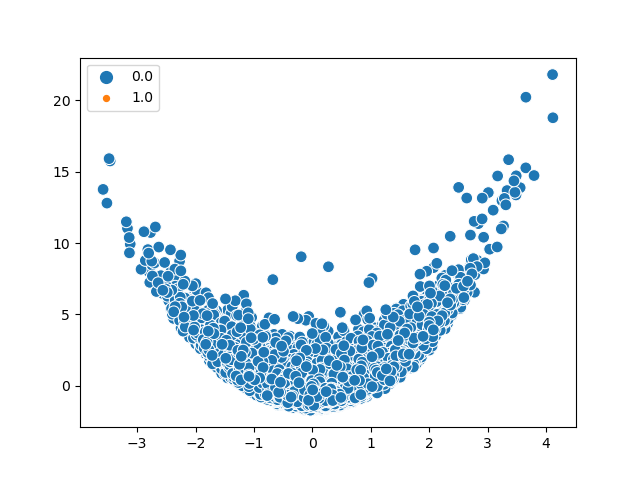

In [11]:
plt.close('all')
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
# sns.scatterplot(x=feature[feature[:,-1]==1,0],y=feature[feature[:,-1]==1,2],hue=feature[feature[:,-1]==1,2])
# sns.scatterplot(x=feature[:,0],y=feature[:,1],size=feature[:,-1],hue=feature[:,-1])

# plt.colorbar()
plt.show()